# Steps für Topic Modeling

# Step 1: Einlesen der bereinigten Daten
# Step 2: Filtern nach Genre 'Rap' und Sprache 'Englisch'
# Step 3: Bereinigung der Texte
# Step 4: Tokenization und Lemmatizer
# Step 5: Stop words
# Step 6: Parameter für Modell bestimmen
# Step 7: LDA Modell anwenden
# Step 8: Topics erkunden
# Step 9: Topics visualisieren



In [ ]:
import pandas as pd
from config import data_input_path

In [5]:
df_raw = pd.read_csv(data_input_path)

In [6]:
num_lyrics = 100_000

df = df_raw.sample(num_lyrics)
# df = df_raw

Batchs of data are randomly loaded in the memory. The number of batchs loaded depends on the memory capacity of the computer running the script. For the analysis, we will only works on the random samples loaded (All the data in Kaggle).  

# Exploring the coarse data

Let's visualize and explore the coarse data before a part of deeper analysis.

In [ ]:
df.head()

For each songs, we've got several informations :
- title of the song
- the tag (genre)
- the artist singer name
- the release year
- the number of page views
- the featuring artists names
- the lyrics
- the genius identifier
- Lyrics language according to [CLD3](https://github.com/google/cld3). Not reliable results are NaN. CLD3 is a neural network model for language indentification.
- Lyrics language according to [FastText's langid](https://fasttext.cc/docs/en/language-identification.html). Values with low confidence (<0.5) are NaN. FastText's langid is library developped by Facebook’s AI Research lab for efficient learning of word representations and sentence classification. fastText has also published a fast and accurate tool for text-based language identification capable of recognizing more than 170 languages.
- Combines language_cld3 and language_ft. Only has a non NaN entry if they both "agree".

In [ ]:
df.dtypes

In [ ]:
# display the size
print('Data frame size (row x columns):', df.size)
print('Data rows number: ', len(df))
print('Number of unique songs (following genius id): ', len(df.id.unique()))

Genius id seems to be the unique rows identifier.

Let's vizualise size of the coarse data over years before preprocessing to compare batch distributions. One things to know before vizualise the data, the pickles are create by chunks reading. 

The last diplayed table gives us some information about the data. The csv file seems to be sort by id, so the pickle files are then sort too.

In [ ]:
import os
import pandas as pd
import plotly.express as px

In [ ]:
# get some information about the pickle data
def pickle_informations(loader: Loader):
    rows = []
    for i in range(1, len(os.listdir('data')) + 1):
        df = loader.load_pickle(i)
        rows.append(len(df))
        del df
    return rows

# get the rows
rows = pickle_informations(loader=loader)

# create the dataframe
df_data = pd.DataFrame(
    {'batch' : ['data ' + str(i) for i in range(1,len(rows) + 1)],
    'rows' : rows})

fig = px.bar(df_data, x="batch", y="rows")
fig.show()

Batch seems to have the same number of rows rexcept for the last one which is consistent because batch are create iteratively by 10e6 chunks over the csv The last batch could be seen as a rest.

In [ ]:
from utils.plots import multi_barplot
import plotly.colors as col

# create the color list
colors = col.qualitative.Plotly

# 1990 - 2023
fig1 = multi_barplot(year1=1960, year2=1989, colors=colors, loader=loader)
fig1.show()
# 1960 - 1990
fig2 = multi_barplot(year1=1990, year2=2023, colors=colors, loader=loader)
fig2.show()

The first bar chart (1960 - 1989) shows an increasing numbers of data over years. Moreover batch seems to have quite similar distriutions over years. data_1 and data_2 batch quite outperform the 4 others. data_6 batch is weaker than the other due to its poor number of rows.
The data behaves similarly until 2012 as we can see on the second chart (1990-2023). After this year there is great increasing of the data retrieved. A minimum increase of at least 100% of the batch can be observed. An increase of up to 50 times the batch size for some.

# Data pre-processing

The aim of this part is to preprocess data in order to get suitable data for the analysis. let's focus on the year variable.

We will focus on English songs, to facilitate the analysis and the work of natural language processing algorithms.

In [7]:
# filter by language
df = df[df.language == 'en']

# filter by genre 
df = df[df.tag == 'rap']

In [8]:
print(f"Num rows: {len(df)}")

Num rows: 18792


In [9]:
start_year = 1960
end_year = 2024

# filter by year
df = df[(df.year >= start_year) & (df.year <= end_year)]

In [10]:
print(f"Num rows: {len(df)}")

Num rows: 18770


In [11]:
# drop nan values
df = df.dropna(subset=['lyrics'])

In [12]:
print(f"Num rows: {len(df)}")

Num rows: 18770


In [13]:
# remove artitst starts with 'Genius'
df = df[~df.artist.str.startswith('Genius')]

In [14]:
print(f"Num rows: {len(df)}")

Num rows: 18684


In [ ]:
df.head()

## Clean lyrics

In [ ]:
# get the first lyrics
df.iloc[0]["lyrics"]

There is many undesirable characters like the line breaker '\n', figures or square, curly and simple brackets. So let's clean this data with regular expressions.

In [15]:
import re
from numpy.random import randint

def clean_text(text):
    # remove \n
    text = text.replace('\n', ' ')
    # remove punctuation
    text = re.sub(r'[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub(r'\[.*?\]', ' ', text)
    #removing numbers
    text = re.sub(r'\w*\d\w*',' ', text)
    #removing bracket
    text = re.sub(r'[()]', ' ', text)
    # convert all words in lower case
    text = text.lower()
    return text

In [16]:
# get the results of data cleaning
cleaned_text = df["lyrics"].apply(clean_text)

# convert cleaned text to list
docs = cleaned_text.to_list()
docs[0]

'  sometimes i feel like i\'m caught in a verse or i\'m bobby fischer but nobody cared to search can\'t look my mother in the eye no mo\' can\'t tell her that the i don\'t get high no mo\' its the begining of a train wreck hold ya heart cause believe me the camera won\'t explain it or contain it an angel said "free" was i really what you wanted me to be you trust the soul of the icey cold because they bump you where guns and the drugs is sold and where the gods said they\'re born to roll and they\'ll think like this until they gray and old i think back to when i was drug free care free but that was long ago kinda like a memory do you remember me man it was long ago we used to like each other livin in the fillmoe you never said no i never said ho but like i said in the begining that was long ago and from the start yo you knew i wasn\'t mozart marvin gaye always said life comes apart and like a puzzle some times it gets worse i\'d probably break down if i step into church   man we had dr

In [17]:
# update dataframe
df.update(cleaned_text)
df.head(3)

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
17282,Caught in a Verse,rap,Andre Nickatina & Equipto,2005,6323,{},sometimes i feel like i'm caught in a verse ...,18136,en,en,en
3694012,BDMTHRFCKR,rap,Malibu Shark Attack!,2014,18,{},just as the party started rockin' came a kno...,5581698,en,en,en
2370444,Voicemail,rap,Juan Pablo,2018,19,{},i ain’t gonna act like i ain’t mad nah whe...,3579916,en,en,en


In [18]:
df.iloc[0]['lyrics']

'  sometimes i feel like i\'m caught in a verse or i\'m bobby fischer but nobody cared to search can\'t look my mother in the eye no mo\' can\'t tell her that the i don\'t get high no mo\' its the begining of a train wreck hold ya heart cause believe me the camera won\'t explain it or contain it an angel said "free" was i really what you wanted me to be you trust the soul of the icey cold because they bump you where guns and the drugs is sold and where the gods said they\'re born to roll and they\'ll think like this until they gray and old i think back to when i was drug free care free but that was long ago kinda like a memory do you remember me man it was long ago we used to like each other livin in the fillmoe you never said no i never said ho but like i said in the begining that was long ago and from the start yo you knew i wasn\'t mozart marvin gaye always said life comes apart and like a puzzle some times it gets worse i\'d probably break down if i step into church   man we had dr

# Topic modeling

- [LDA (latent dirichlet allocation)](https://fr.wikipedia.org/wiki/Allocation_de_Dirichlet_latente) are the common way to do topic modeling in the few last years, it works and it's quite easy to use with common python library like [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html).

## Define default tokenizer and Lemmatizer

In [ ]:
from utils.terms_document_matrix import TermsDocumentsMatrix
from utils.processing import preprocess

In [ ]:
# first decades
tdm = TermsDocumentsMatrix(df, decades = [1960, 1970, 1980, 1990],
                           colorscale = 'Plasma')

# display bar charts of most frequent terms
tdm.most_freq_terms(n_rows = 2, n_cols = 2, n_terms = 15)

According to the bar graphs displayed above, a group of words seems to recur on each decade: Love, know, go, feel ... Words that seem to relate to the popular song that can talk about love. This is consistent with our previous analysis from the pie charts showing the proportions of musical styles across time. We also notice an important presence of onomatopoeia like yeah or oh.

In [ ]:
# first decades
tdm = TermsDocumentsMatrix(df, decades = [2000, 2010, 2020],
                          colorscale = 'Plasma')

# most frequent terms
tdm.most_freq_terms(n_rows = 2, n_cols = 2, n_terms = 15)

We get similar results on this second decade with similar high occurrence words. We see a greater amount of onomatopoeia in the current decade. We can explain this by an emergence of the rap music style on this current and last decade. There is in this style of music a very used process, the 'ad-libs'. They are sounds, words or onomatopoeias that the artists pronounce sometimes between two verses or at the end of a sentence to give more impact to their text and to dynamize the atmosphere of a title. This may explain the greater presence of onomatopoeia in the lyrics of this decade.


## Topic modeling with LDA

LDA is a common technic use in topic modeling, we firstly process basic preprocessing.

In [ ]:
import nltk

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.lyrics])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.lyrics])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [ ]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
# Filter for bigrams with only noun-type structures
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_word_list = set(stopwords.words('english'))

def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [ ]:
# examples of bigrams
bigrams[:10]

In [ ]:
# examples of trigrams
trigrams[:10]

In [ ]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [ ]:
lyrics_w_ngrams = df.copy()
lyrics_w_ngrams.reviewText = lyrics_w_ngrams.lyrics.map(lambda x: replace_ngram(x))

In [ ]:
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
lyrics_w_ngrams = lyrics_w_ngrams.lyrics.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                            #   and word not in english_names\
                                                              and len(word) > 2])

In [ ]:
lyrics_w_ngrams.head()

In [ ]:
from gensim import corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords


nltk.download('stopwords')

# Allgemeine Stop-Wörter
common_stop_words = {
    "a", "an", "and", "are", "as", "at", "be", "by", "for", "from", "he", "her",
    "his", "I", "in", "is", "it", "me", "my", "of", "on", "or", "she", "so",
    "that", "the", "to", "up", "was", "we", "with", "you", "i'm", "i've", "i'll", "i'd", "i", "im", "it's", "its", "don't", "dont", "i’m", "i’ve", "i’ll", "i’d", "i", "im", "it’s", "its", "don’t", "dont",
}

# Spezifische Rap-Stop-Wörter
rap_specific_stop_words = {
    "ain't", "yeah", "yea", "yo", "uh", "huh", "gonna", "wanna", "hey", "ooh", "woo",
    "nah", "got", "gotcha", "cuz", "y'all", "imma", "lil", "flex"
}

# Kombiniertes Set von Stop-Wörtern
rap_stop_words = common_stop_words.union(rap_specific_stop_words)

# concatenate the stop words
stop_words = set(stopwords.words('english')).union(rap_stop_words)

# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

def preprocess_lyrics(lyrics):
    return [word for word in lyrics if word not in stop_words]

lyrics = lyrics_w_ngrams.map(preprocess_lyrics)
final_lyrics = lyrics.map(noun_only)
dictionary = corpora.Dictionary(final_lyrics)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_lyrics]



## Calculate coherence score

In [ ]:
import gensim

coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_lyrics,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

In [ ]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

In [ ]:
from matplotlib import pyplot as plt

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

## Define LDA Model

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=19, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [ ]:
ldamodel.show_topics(19, num_words=30, formatted=False)

In [ ]:
import pyLDAvis.gensim

topic_data =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa', R=10, sort_topics=False)
pyLDAvis.display(topic_data)

In [ ]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import nltk

# NLTK-Stopwörter herunterladen
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Datenvorverarbeitung und Tokenisierung
def preprocess_lyrics(lyrics):
    return [word for word in simple_preprocess(lyrics) if word not in stop_words]


df['tokens'] = df['lyrics'].apply(preprocess_lyrics)


# Erstelle Wörterbuch und Korpus
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# LDA-Modellierung
num_topics = 23
lda_model = LdaModel(
    corpus=corpus, 
    id2word=dictionary, 
    num_topics=num_topics, 
    random_state=42, 
    update_every=1, 
    chunksize=10,
    passes=20, 
    alpha='auto', 
    per_word_topics=True
)

# Themen anzeigen
for idx, topic in lda_model.print_topics(num_words=15):
    print(f"Topic {idx}: {topic}")



In [ ]:
# Visualisierung
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds', R=15)
pyLDAvis.show(vis, local=False)

# Topic Modeling LDA v2

In [19]:
from nltk.tokenize import RegexpTokenizer

lyric_corpus_tokenized = []
tokenizer = RegexpTokenizer(r'\w+')
for lyric in df.lyrics:
    tokenized_lyric = tokenizer.tokenize(lyric.lower())
    lyric_corpus_tokenized.append(tokenized_lyric)

In [20]:
# filter all tokens out that are less than 3 characters long
for s,song in enumerate(lyric_corpus_tokenized):
    filtered_song = []    
    for token in song:
        if len(token) > 2 and not token.isnumeric():
            filtered_song.append(token)
    lyric_corpus_tokenized[s] = filtered_song

In [21]:
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
for s,song in enumerate(lyric_corpus_tokenized):
    lemmatized_tokens = []
    for token in song:
        lemmatized_tokens.append(lemmatizer.lemmatize(token))
    lyric_corpus_tokenized[s] = lemmatized_tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/niklasfischer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stop_words = ["ooh","yeah","hey","whoa","woah", "ohh", "was", "mmm", "oooh","yah","yeh","mmm", "hmm","deh","doh","jah","wa"]
stop_words.extend(new_stop_words)
for s,song in enumerate(lyric_corpus_tokenized):
    if s % 10_000 == 0:
        print(s)
    filtered_text = []    
    for token in song:
        if token not in stop_words:
            filtered_text.append(token)
    lyric_corpus_tokenized[s] = filtered_text

0
10000


In [23]:
from gensim.corpora import Dictionary
dictionary = Dictionary(lyric_corpus_tokenized)
dictionary.filter_extremes(no_below = 100, no_above = 0.8)

In [24]:
from gensim.corpora import MmCorpus
gensim_corpus = [dictionary.doc2bow(song) for song in lyric_corpus_tokenized]
temp = dictionary[0]
id2word = dictionary.id2token

In [52]:
chunksize = 10_000
passes = 40
iterations = 10

## Calculate coherence score

In [29]:
import gensim

coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(gensim_corpus, num_topics=k, id2word = dictionary, passes=passes,\
                   iterations=iterations, chunksize = chunksize, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=lyric_corpus_tokenized,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


In [30]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

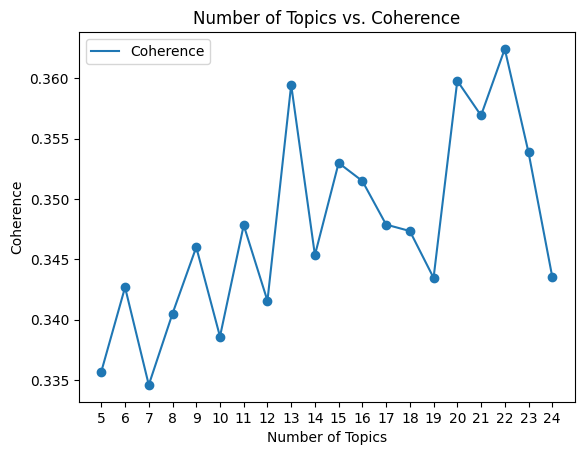

In [37]:
from matplotlib import pyplot as plt

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.legend(['Coherence'])
plt.show()

## Define LDA Model

In [56]:
# get num of topics with max coherence
num_topics = x_val[y_val.index(max(y_val))]
num_topics

22

In [57]:
load_from_disk = False

from gensim.models import LdaModel
from gensim.test.utils import datapath

model_path = datapath("model")

if load_from_disk:
    lda_model = LdaModel.load(model_path)
else:
    lda_model = LdaModel(
        corpus=gensim_corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes
    )

## Get coherence score

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
coherencemodel = CoherenceModel(model=lda_model, texts=lyric_corpus_tokenized, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

## Get Perplexity

In [47]:
print('\nPerplexity: ', lda_model.log_perplexity(gensim_corpus))


Perplexity:  -9.540800609490892


## Generate pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, gensim_corpus, dictionary)
#pyLDAvis.display(vis_data)
pyLDAvis.save_html(vis_data, f'./Lyrics_LDA_k_{str(num_topics)}_n_{str(len(df))}.html')

## Save models

In [ ]:
from gensim.test.utils import datapath

#saving model to disk.

temp_file = datapath("model")

lda_model.save(temp_file)

In [ ]:
temp_file = datapath("coherencemodel")

coherencemodel.save(temp_file)